<a href="https://colab.research.google.com/github/martian099/BambulabGcode/blob/main/240802_test_unbalanced_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
# test if I can split a test loader into pos and neg ones
X=torch.rand(10, 2)
print(X)
y = torch.randint(0, 2, (10, ))
print(y)
# create train data loader from X and y
data_loader = TensorDataset(X, y)
print(data_loader.tensors[0])
print(data_loader.tensors[1])
# now split it into 0 and 1 datapoints
pos_data_loader = TensorDataset(
    data_loader.tensors[0][data_loader.tensors[1]==1],
    data_loader.tensors[1][data_loader.tensors[1]==1],
    )
neg_data_loader = TensorDataset(
    data_loader.tensors[0][data_loader.tensors[1]==0],
    data_loader.tensors[1][data_loader.tensors[1]==0],
    )

tensor([[0.5684, 0.3472],
        [0.6677, 0.2640],
        [0.7954, 0.3003],
        [0.8089, 0.0351],
        [0.0166, 0.9649],
        [0.9132, 0.3912],
        [0.6568, 0.5411],
        [0.8672, 0.9870],
        [0.3037, 0.6917],
        [0.1436, 0.7473]])
tensor([1, 1, 0, 0, 1, 1, 1, 0, 1, 0])
tensor([[0.5684, 0.3472],
        [0.6677, 0.2640],
        [0.7954, 0.3003],
        [0.8089, 0.0351],
        [0.0166, 0.9649],
        [0.9132, 0.3912],
        [0.6568, 0.5411],
        [0.8672, 0.9870],
        [0.3037, 0.6917],
        [0.1436, 0.7473]])
tensor([1, 1, 0, 0, 1, 1, 1, 0, 1, 0])


In [84]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

def main(threshold):
    # create a new column for binarized (boolean) quality
    data['boolQuality'] = 0
    # data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
    data['boolQuality'][data['quality']>threshold] = 1

    # convert from pandas dataframe to tensor
    dataT  = torch.tensor( data[cols2zscore].values ).float()
    labels = torch.tensor( data['boolQuality'].values ).float()
    labels = labels[:,None] # transform to matrix

    # use scikitlearn to split the data
    train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

    # then convert them into PyTorch Datasets (note: already converted to tensors)
    train_data = torch.utils.data.TensorDataset(train_data,train_labels)
    test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

    # finally, translate into dataloader objects
    batchsize    = 64
    train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
    test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

    # create a class for the model
    class ANNwine(nn.Module):
        def __init__(self,actfun):
            super().__init__()

            ### input layer
            self.input = nn.Linear(11,16)

            ### hidden layers
            self.fc1 = nn.Linear(16,32)
            self.fc2 = nn.Linear(32,32)

            ### output layer
            self.output = nn.Linear(32,1)

            # activation funcion to pass through
            self.actfun = actfun

        # forward pass
        def forward(self,x):
            # get activation function type
            # this code replaces torch.relu with torch.<self.actfun>
            actfun = getattr(torch.nn,self.actfun)
            x = actfun()( self.input(x) )
            x = actfun()( self.fc1(x) )
            x = actfun()( self.fc2(x) )
            return self.output(x)

    # a function that trains the model
    # global parameter
    numepochs = 200

    def trainTheModel():
        # loss function and optimizer
        lossfun = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(winenet.parameters(),lr=.01)

        # initialize losses
        losses   = torch.zeros(numepochs)
        trainAcc = []
        testAcc  = []
        testPosAcc = []
        testNegAcc = []

        # loop over epochs
        for epochi in range(numepochs):

            # switch on training mode
            winenet.train()

            # loop over training data batches
            batchAcc  = []
            batchLoss = []
            for X,y in train_loader:

                # forward pass and loss
                yHat = winenet(X)
                loss = lossfun(yHat,y)

                # backprop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # loss from this batch
                batchLoss.append(loss.item())

                # compute training accuracy for this batch
                batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
                # end of batch loop...

            # now that we've trained through the batches, get their average training accuracy
            trainAcc.append( np.mean(batchAcc) )

            # and get average losses across the batches
            losses[epochi] = np.mean(batchLoss)

            # test accuracy
            winenet.eval()
            X,y = next(iter(test_loader)) # extract X,y from test dataloader
            # get positive and negative tensors
            X_pos = X[(y==1).squeeze()]
            y_pos = y[(y==1).squeeze()]
            X_neg = X[(y==0).squeeze()]
            y_neg = y[(y==0).squeeze()]

            with torch.no_grad(): # deactivates autograd
                yHat = winenet(X)
                testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
                y_pos_hat = winenet(X_pos)
                testPosAcc.append( 100*torch.mean(((y_pos_hat>0) == y_pos).float()).item())
                y_neg_hat = winenet(X_neg)
                testNegAcc.append( 100*torch.mean(((y_neg_hat>0) == y_neg).float()).item())

        # function output
        return trainAcc,testAcc,losses, testPosAcc, testNegAcc

    # get the train and test accuracy
    activation_funs = [ 'LeakyReLU' ]

    trainByAct = np.zeros((numepochs,len(activation_funs)))
    testByAct  = np.zeros((numepochs,len(activation_funs)))
    testPos = np.zeros((numepochs,len(activation_funs)))
    testNeg = np.zeros((numepochs,len(activation_funs)))

    for ai,actfun in enumerate(activation_funs):
        # create a model and train it
        winenet = ANNwine(actfun)
        trainByAct[:,ai],testByAct[:,ai],losses, testPos[:, ai], testNeg[: ,ai] = trainTheModel()


    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    # plot the results
    fig,ax = plt.subplots(2,2,figsize=(20,7))
    ax[0, 0].plot(trainByAct)
    ax[0, 0].set_title('Train accuracy')
    ax[0, 1].plot(testByAct)
    ax[0, 1].set_title('Test accuracy')
    ax[1, 0].plot(testPos)
    ax[1, 0].set_title(f'Test accuracy for pos {y[(y==1).squeeze()].shape}')
    ax[1, 1].plot(testNeg)
    ax[1, 1].set_title(f'Test accuracy for neg {y[(y==0).squeeze()].shape}')
    # common features
    for i in range(2):
        for j in range(2):
            ax[i, j].legend(activation_funs)
            ax[i, j].set_xlabel('Epoch')
            ax[i, j].set_ylabel('Accuracy (%)')
            ax[i, j].set_ylim([0,100])
            ax[i, j].grid()

    plt.show()

<ipython-input-84-191405915dec>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>threshold] = 1


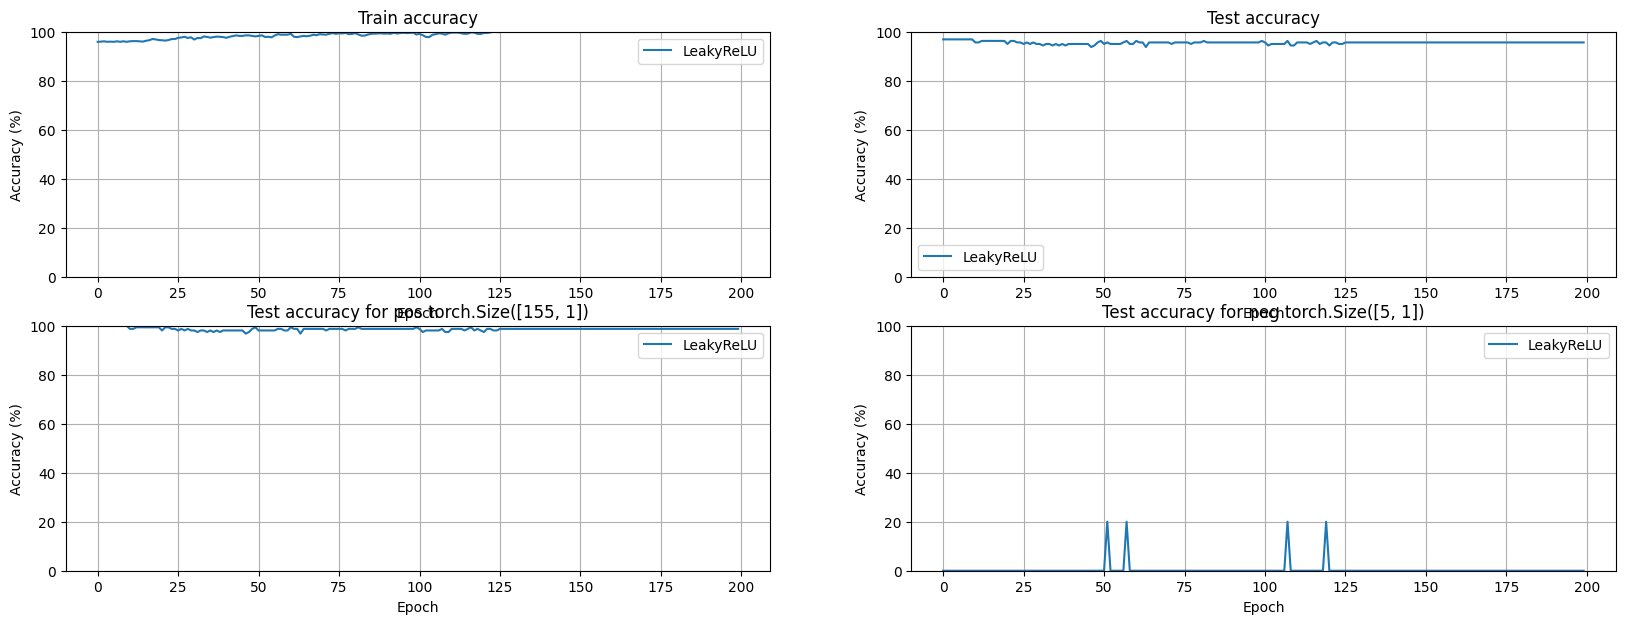

<ipython-input-84-191405915dec>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>threshold] = 1


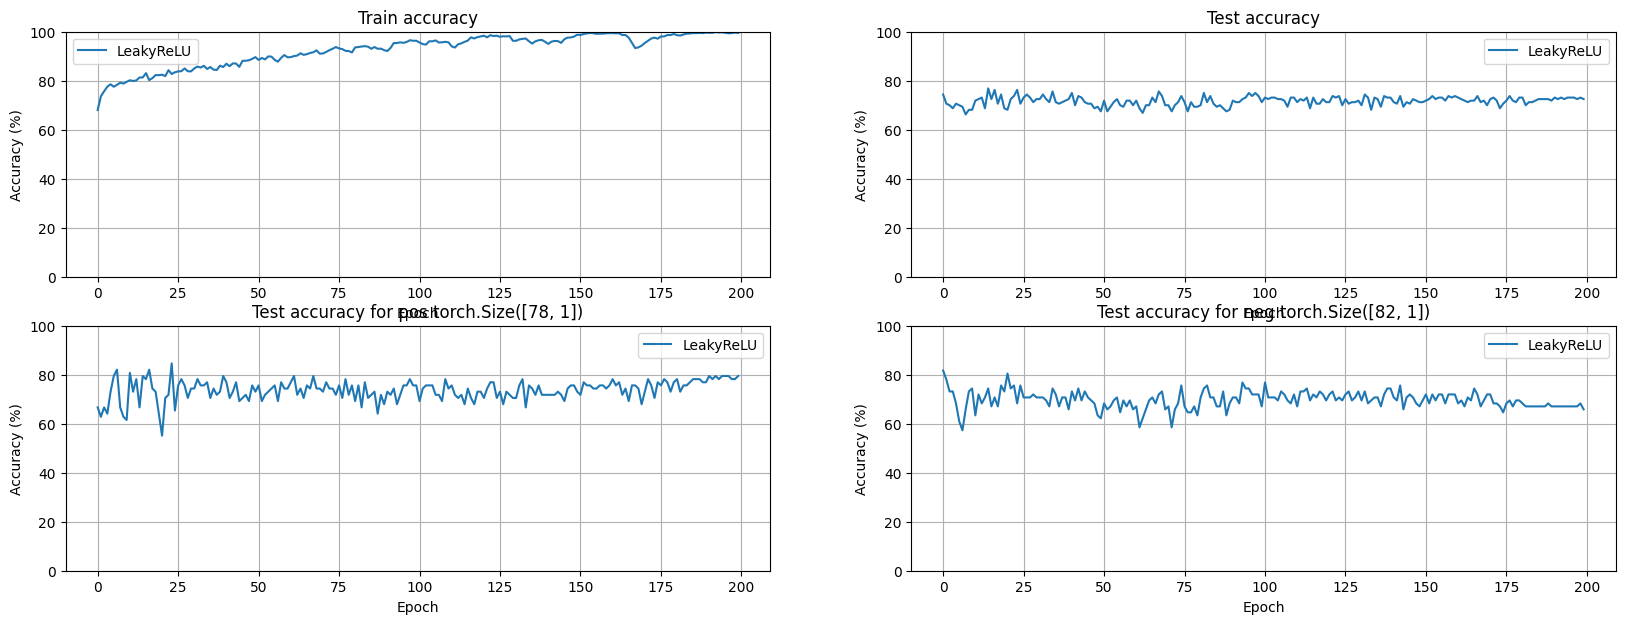

<ipython-input-84-191405915dec>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>threshold] = 1


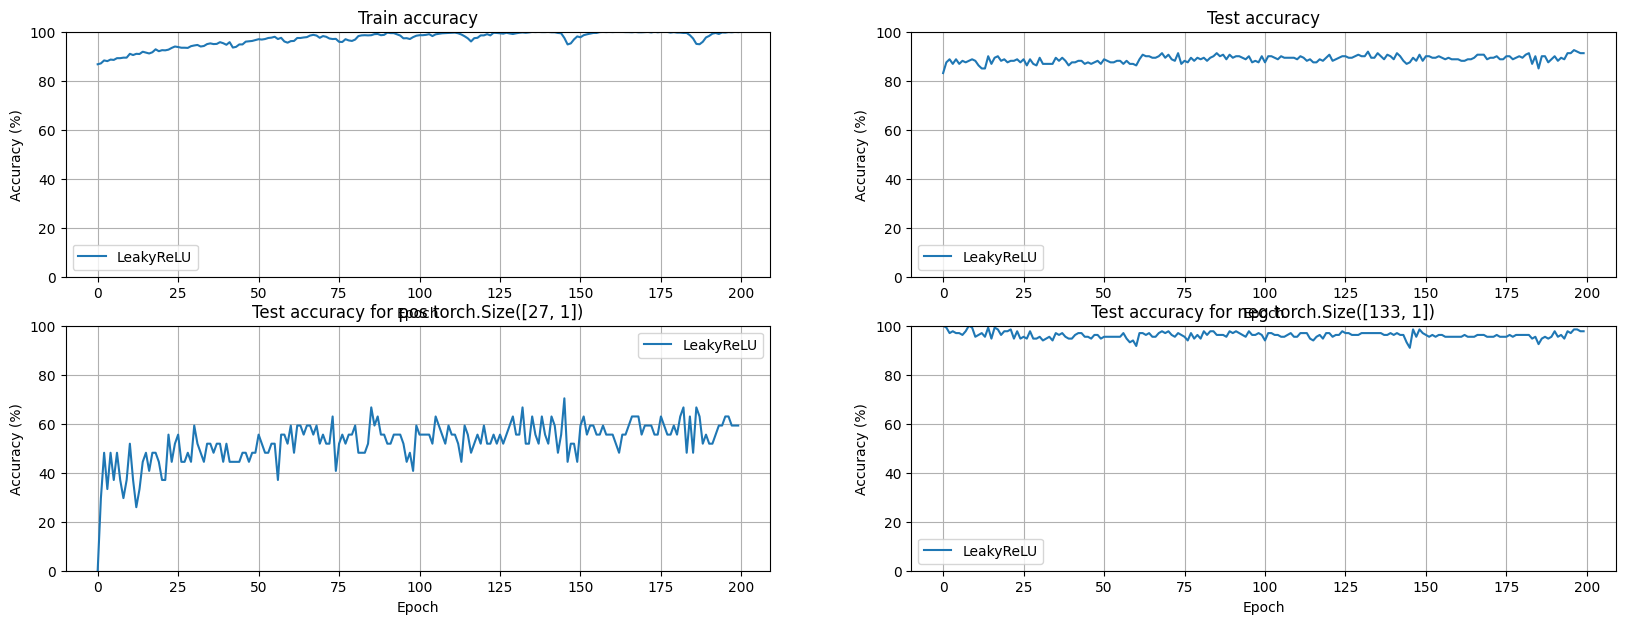

In [85]:
main(4.5)
main(5.5)
main(6.5)